In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nibabel as nib
import cv2 as cv
import os
from IPython.display import Image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,MaxPool2D,Concatenate, Activation, BatchNormalization,concatenate ,Input
from tensorflow.keras.models import Model
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import skimage.transform as st

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model

In [3]:

def conv_block(input,num_filter):
    x=Conv2D(filters=num_filter,kernel_size=3,padding="same")(input)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=Conv2D(filters=num_filter,kernel_size=3,padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    return x

def decoder(input,skip_feature,num_filter):
    x=Conv2DTranspose(filters=num_filter,kernel_size=2,strides=2,padding="same")(input)
    x=concatenate([x,skip_feature])
    x=conv_block(x,num_filter)
    return x


def segmentation_model(input_shape):
    inputs=Input(shape=input_shape,name="input")
    res=ResNet50(include_top=False,weights="imagenet",input_tensor=inputs)
    res.trainable=False
    s1=res.get_layer("input").output
    s2=res.get_layer("conv1_relu").output
    s3=res.get_layer("conv2_block3_out").output
    s4=res.get_layer("conv3_block4_out").output
    
    
    feature=res.get_layer("conv4_block6_out").output
    
    d1=decoder(feature,s4,512)
    d2=decoder(d1,s3,256)
    d3=decoder(d2,s2,128)
    d4=decoder(d3,s1,64)
    
    outputs=Conv2D(4,(1,1),padding="same",activation="softmax")(d4)
    model=Model(inputs,outputs,name="Unet_res")
    return model

def classification_model(input_shape):
    inputs=Input(shape=input_shape,name="input")
    googlenet=InceptionV3(include_top=False,weights="imagenet",input_tensor=inputs)
    googlenet.trainable=False
    feature=googlenet.get_layer("mixed8").output
    flattern=tf.keras.layers.Flatten()(feature)
    flattern=tf.keras.layers.Dropout(0.3)(flattern)
    Dense1=tf.keras.layers.Dense(128,activation='relu')(flattern)
    outputs=tf.keras.layers.Dense(4,activation="softmax")(Dense1)
    model=Model(inputs,outputs,name="classfication_inc")
    return model

def classification_resnet(input_shape):
    inputs=Input(shape=input_shape,name="input")
    res=ResNet50(include_top=False,weights="imagenet",input_tensor=inputs)
    res.trainable=False
    Feature=res.get_layer("conv4_block6_out").output   
    flattern=tf.keras.layers.Flatten()(Feature)
    flattern=tf.keras.layers.Dropout(0.3)(flattern)
    Dense1=tf.keras.layers.Dense(128,activation='relu')(flattern)
    outputs=tf.keras.layers.Dense(4,activation="softmax")(Dense1)
    model=Model(inputs,outputs,name="classfication_inc")
    return model

# classification

In [4]:
model=classification_model((256,256,3))
model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "classfication_inc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)      

In [5]:
model2=classification_resnet((256,256,3))
model2.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "classfication_inc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                 

In [6]:
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])
model2.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [7]:
x_train=np.load('/content/drive/MyDrive/classification_image.npy').astype(np.float32)
label=np.load("/content/drive/MyDrive/classification_label.npy").astype(np.float32)

Creating Googlenet checkpoints

In [8]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints_gnet'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
callbackg=tf.keras.callbacks.ModelCheckpoint(monitor="loss",filepath=checkpoint_prefix,save_weights_only=True)


In [9]:
history=model.fit(x_train,label,batch_size=20,epochs=100,callbacks=[callbackg])

Epoch 1/100
25/25 [==============================] - 17s 114ms/step - loss: 289.1070 - accuracy: 0.3569
Epoch 2/100
25/25 [==============================] - 2s 99ms/step - loss: 24.8784 - accuracy: 0.6089
Epoch 3/100
25/25 [==============================] - 2s 79ms/step - loss: 11.5385 - accuracy: 0.6411
Epoch 4/100
25/25 [==============================] - 2s 82ms/step - loss: 12.3074 - accuracy: 0.6734
Epoch 5/100
25/25 [==============================] - 3s 105ms/step - loss: 5.6239 - accuracy: 0.7540
Epoch 6/100
25/25 [==============================] - 2s 80ms/step - loss: 4.9605 - accuracy: 0.7722
Epoch 7/100
25/25 [==============================] - 2s 80ms/step - loss: 5.4470 - accuracy: 0.7782
Epoch 8/100
25/25 [==============================] - 2s 97ms/step - loss: 10.4932 - accuracy: 0.7137
Epoch 9/100
25/25 [==============================] - 2s 79ms/step - loss: 7.0797 - accuracy: 0.7621
Epoch 10/100
25/25 [==============================] - 2s 81ms/step - loss: 6.6841 - accurac

Creating Resnet-50 checkpoints

In [10]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints_resnet'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
callbackr=tf.keras.callbacks.ModelCheckpoint(monitor="loss",filepath=checkpoint_prefix,save_weights_only=True)


In [11]:
history2=model2.fit(x_train,label,batch_size=20,epochs=20,callbacks=[callbackr])

Epoch 1/20
25/25 [==============================] - 7s 176ms/step - loss: 47.9167 - accuracy: 0.4556
Epoch 2/20
25/25 [==============================] - 4s 170ms/step - loss: 4.1837 - accuracy: 0.7641
Epoch 3/20
25/25 [==============================] - 4s 150ms/step - loss: 2.8947 - accuracy: 0.8266
Epoch 4/20
25/25 [==============================] - 4s 148ms/step - loss: 1.1867 - accuracy: 0.8992
Epoch 5/20
25/25 [==============================] - 5s 185ms/step - loss: 0.7719 - accuracy: 0.9254
Epoch 6/20
25/25 [==============================] - 4s 150ms/step - loss: 0.6787 - accuracy: 0.9395
Epoch 7/20
25/25 [==============================] - 3s 141ms/step - loss: 0.3645 - accuracy: 0.9496
Epoch 8/20
25/25 [==============================] - 4s 180ms/step - loss: 0.2938 - accuracy: 0.9577
Epoch 9/20
25/25 [==============================] - 4s 147ms/step - loss: 0.0784 - accuracy: 0.9819
Epoch 10/20
25/25 [==============================] - 4s 147ms/step - loss: 0.0372 - accuracy: 0.987

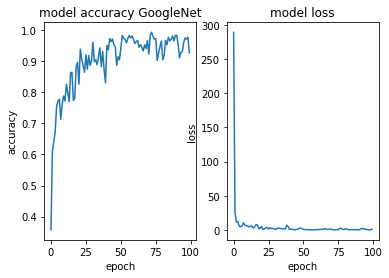

In [12]:
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.title("model accuracy GoogleNet")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.subplot(122)
plt.plot(history.history['loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

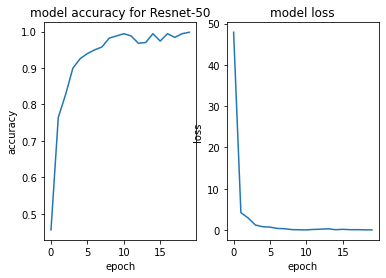

In [13]:
plt.subplot(121)
plt.plot(history2.history['accuracy'])
plt.title("model accuracy for Resnet-50")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [14]:
y_pred=model(x_train)
pred=np.argmax(y_pred,axis=-1)
y_pred2=model2(x_train)
pred2=np.argmax(y_pred2,axis=-1)

actual=np.argmax(label,axis=-1)

Confusion matrix

In [15]:

result=multilabel_confusion_matrix(actual,pred)
result2=multilabel_confusion_matrix(actual,pred2)
print(result)
print(result2)

[[[429   1]
  [  0  66]]

 [[286   5]
  [  0 205]]

 [[371   0]
  [  6 119]]

 [[396   0]
  [  0 100]]]
[[[430   0]
  [  0  66]]

 [[291   0]
  [  0 205]]

 [[371   0]
  [  0 125]]

 [[396   0]
  [  0 100]]]


Classification Report

In [16]:
report1 = classification_report(actual,pred)
report2 = classification_report(actual,pred2)
print(report1)
print(report2)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        66
           1       0.98      1.00      0.99       205
           2       1.00      0.95      0.98       125
           3       1.00      1.00      1.00       100

    accuracy                           0.99       496
   macro avg       0.99      0.99      0.99       496
weighted avg       0.99      0.99      0.99       496

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00       205
           2       1.00      1.00      1.00       125
           3       1.00      1.00      1.00       100

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496



Loading checkpoints for classification

In [17]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints_gnet/'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
model.load_weights(checkpoint_prefix)

In [18]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints_resnet/'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
model2.load_weights(checkpoint_prefix)

Sample Image prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


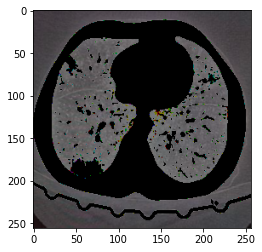

In [19]:
plt.imshow(x_train[0].astype(np.int8))

In [20]:
pred2[4]

0

In [21]:
actual[4]

0

# Segmentation

In [22]:
seg_model=segmentation_model((512,512,3))
seg_model.summary()

Model: "Unet_res"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [23]:
images=np.load("/content/drive/MyDrive/images_medseg.npy").astype(np.float32)
mask=np.load("/content/drive/MyDrive/masks_medseg.npy").astype(np.float32)

In [25]:
timage=[]
for image in images:
    new_image=cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    timage.append(new_image)
timages=np.array(timage)
fimages=cv.normalize(timages,None,0,255,cv.NORM_MINMAX,cv.CV_32F).astype(np.int8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


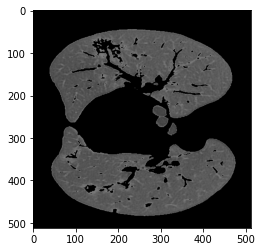

In [26]:
plt.imshow(fimages[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


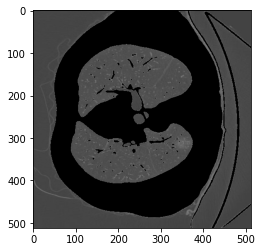

In [27]:
plt.imshow(fimages[2])

In [28]:
# Run while training only
seg_model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.14),loss='binary_crossentropy',metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints_new'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
callback2=tf.keras.callbacks.ModelCheckpoint(monitor="loss",filepath=checkpoint_prefix,save_weights_only=True)

In [ ]:
# Run while training only
seg_history=seg_model.fit(fimages,mask,batch_size=1,epochs=100,verbose=1,callbacks=[callback2])

Epoch 1/100
100/100 [==============================] - 67s 543ms/step - loss: 0.2378 - mean_io_u: 0.3808
Epoch 2/100
100/100 [==============================] - 54s 536ms/step - loss: 0.1443 - mean_io_u: 0.5075
Epoch 3/100
100/100 [==============================] - 54s 536ms/step - loss: 0.1194 - mean_io_u: 0.6577
Epoch 4/100
100/100 [==============================] - 54s 536ms/step - loss: 0.1122 - mean_io_u: 0.6721
Epoch 5/100
100/100 [==============================] - 53s 535ms/step - loss: 0.1041 - mean_io_u: 0.6790
Epoch 6/100
100/100 [==============================] - 54s 540ms/step - loss: 0.1020 - mean_io_u: 0.7061
Epoch 7/100
100/100 [==============================] - 54s 536ms/step - loss: 0.0989 - mean_io_u: 0.7232
Epoch 8/100
100/100 [==============================] - 54s 535ms/step - loss: 0.0931 - mean_io_u: 0.7268
Epoch 9/100
100/100 [==============================] - 54s 536ms/step - loss: 0.0916 - mean_io_u: 0.7347
Epoch 10/100
100/100 [==============================] -

dict_keys(['loss', 'mean_io_u'])


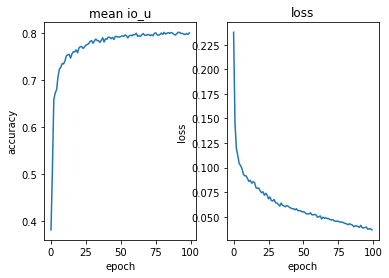

In [ ]:
# Run while training only
print(seg_history.history.keys())
plt.subplot(121)
plt.plot(seg_history.history['mean_io_u'])
plt.title("mean io_u")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.subplot(122)
plt.plot(seg_history.history['loss'])
plt.title("loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.savefig('output.jpg')
plt.show()

Loading checkpoint

In [29]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints_new/'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
seg_model.load_weights(checkpoint_prefix)

Output

In [30]:
image_no=4
image=np.array([fimages[image_no]])
predseg=seg_model(image)
image_predmask=predseg[0]
image_actmask=mask[image_no]
pred_mask=np.argmax(predseg[0],axis=-1)
act_mask=np.argmax(mask[image_no],axis=-1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


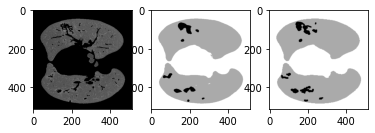

In [31]:

plt.subplot(131);plt.imshow(image[0])
plt.subplot(132);plt.imshow(pred_mask,cmap='gray')
plt.subplot(133);plt.imshow(act_mask,cmap='gray')

Spreading calculation

In [33]:
def spreading(image):
    carry=np.unique(image,return_counts=True)
    dict={0:0,1:0,2:0,3:0}
    for i in range(len(carry[0])):
        dict[carry[0][i]]=carry[1][i]
    return dict[0]*100/(dict[1]+dict[0]+dict[2])

In [34]:
spreading(pred_mask),spreading(act_mask)

(4.44699827616359, 5.414174355049375)

Calculating Dice Coefficient

In [35]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [36]:
dice(act_mask, pred_mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


0.9946530325501522

In [37]:
ttimages=x_train[0:10]

In [38]:
test_images=[]
for i in ttimages:
    s=cv.resize(i,(512,512))
    test_images.append(s)
test_images[0].shape

(512, 512, 3)

In [39]:
t_images=np.array(test_images)


In [40]:
pred_timage=seg_model(t_images)

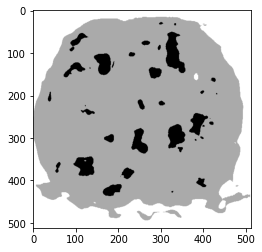

In [41]:
test_img=pred_timage[0]
test_img=np.argmax(test_img,axis=-1)
plt.imshow(test_img,cmap='gray')


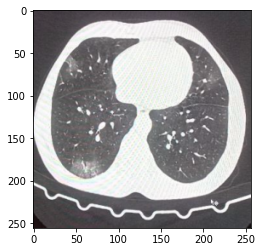

In [42]:
plt.imshow(x_train[0].astype('uint8'))